In [1]:
using ReverseDiff
using Turing
Turing.setadbackend(:reversediff)
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using FITSIO
using ForwardDiff
using PythonCall
using BenchmarkTools;

In [2]:
np = pyimport("numpy")

fol = "DESY1"
data_set = "gcgc_gcwl_wlwl"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
pairs_ids = pyconvert(Vector{Vector{Int}}, meta["pairs_ids"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [3]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [4]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [5]:
pars = carlos_params1
nuisances = Dict("DESgc__0_0_b" => pars[5],
                 "DESgc__1_0_b" => pars[6],
                 "DESgc__2_0_b" => pars[7],
                 "DESgc__3_0_b" => pars[8],
                 "DESgc__4_0_b" => pars[9],
                 "DESgc__0_0_dz" => pars[10],
                 "DESgc__1_0_dz" => pars[11],
                 "DESgc__2_0_dz" => pars[12],
                 "DESgc__3_0_dz" => pars[13],
                 "DESgc__4_0_dz" => pars[14],

                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16],

                 "DESwl__0_e_dz" => pars[21],
                 "DESwl__1_e_dz" => pars[22],
                 "DESwl__2_e_dz" => pars[23],
                 "DESwl__3_e_dz" => pars[24],
                 "DESwl__0_e_m" => pars[17],
                 "DESwl__1_e_m" => pars[18],
                 "DESwl__2_e_m" => pars[19],
                 "DESwl__3_e_m" => pars[20])

Dict{String, Float64} with 20 entries:
  "DESwl__2_e_dz" => -0.00109794
  "DESwl__3_e_m"  => -0.00111773
  "A_IA"          => 0.238921
  "DESwl__0_e_m"  => 0.00180272
  "DESwl__3_e_dz" => -0.00491232
  "DESgc__3_0_dz" => 0.00119705
  "DESgc__1_0_b"  => 1.63905
  "DESgc__2_0_b"  => 1.59717
  "DESwl__1_e_dz" => 0.00677778
  "DESwl__1_e_m"  => -0.00550899
  "DESgc__4_0_dz" => -0.0051998
  "DESgc__3_0_b"  => 1.94458
  "DESwl__2_e_m"  => 0.0195251
  "DESgc__1_0_dz" => -0.00284
  "DESgc__0_0_dz" => -0.00467938
  "DESgc__4_0_b"  => 2.00725
  "alpha_IA"      => -0.643529
  "DESgc__0_0_b"  => 1.34389
  "DESwl__0_e_dz" => -0.0174408
  "DESgc__2_0_dz" => 0.00177157

In [17]:
function make_cls(pars; mode="EisHu", nuisances = nuisances)

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=mode, Pk_mode="Halofit", 
                                     nk=200, nz=200, nz_pk=100)

    return Theory(cosmology, tracers_names, pairs,
                  pairs_ids, idx, files;
                  Nuisances=nuisances)

end

make_cls (generic function with 1 method)

In [18]:
@benchmark make_cls(pars)

BenchmarkTools.Trial: 130 samples with 1 evaluation.
 Range (min … max):  20.176 ms … 95.415 ms  ┊ GC (min … max):  0.00% … 58.05%
 Time  (median):     37.852 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   38.579 ms ± 12.823 ms  ┊ GC (mean ± σ):  10.87% ± 18.17%

                  █▂                                           
  ▆▃▁▂▄▄▄▂▄▃▂▃▃▆▆▅██▄▄▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▄▂▄▃▁▁▁▁▁▁▁▁▁▂ ▂
  20.2 ms         Histogram: frequency by time          83 ms <

 Memory estimate: 24.10 MiB, allocs estimate: 49581.

## plot lkl

In [7]:
#using Plots
function make_Xi(Ωm, s8; pars=pars, mode="EisHu", nuisances=nuisances)
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=mode, Pk_mode="Halofit")

    theory = Theory(cosmology, tracers_names, pairs,
                    pairs_ids, idx, files;
                    Nuisances=nuisances)
    return dot((theory .- data_vector), inv_cov_tot  * (theory .- data_vector))
end

make_Xi (generic function with 1 method)

In [19]:
Ωms = LinRange(0.1, 0.6, 10)
s8s = LinRange(0.6, 0.9, 10)

10-element LinRange{Float64, Int64}:
 0.6,0.633333,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9

In [20]:
Xis1 = [[make_Xi(Ωms[i], s8s[j]) for i in 1:length(Ωms)] for j in 1:length(s8s)]

10-element Vector{Vector{Float64}}:
 [3698.891721109562, 1780.5847004420193, 1725.3448554542642, 1709.4046847106786, 1683.9241504047316, 1665.3269390752637, 1675.6134355843524, 1738.5998900961874, 1869.9155727971836, 2093.089086703927]
 [4116.171027593573, 1604.833608551068, 1499.2396224492306, 1472.9515726208765, 1452.8717662107883, 1454.9958101394075, 1503.6433595285769, 1625.2707031805637, 1838.4102168332097, 2170.8432390638054]
 [4676.474251243173, 1454.8581670322144, 1286.3700604813425, 1248.6974774845603, 1238.2996419694725, 1269.5303574280601, 1368.5539872494508, 1564.3255391856503, 1878.8204125218765, 2345.1806213091127]
 [5402.211220112912, 1337.8403119950244, 1092.1990584856464, 1042.2610686781882, 1046.6793731492407, 1116.544241164355, 1279.2475362037235, 1566.165188615207, 2003.5482614981272, 2631.4621140725076]
 [6318.076557179494, 1261.7689453427624, 922.8116878297649, 859.8641577361749, 885.0473550626258, 1004.1338480732711, 1245.030048744554, 1641.5934770846743, 2225.56

In [21]:
Xis2 = [[make_Xi(Ωms[i], s8s[j]; mode="emulator") for i in 1:length(Ωms)] for j in 1:length(s8s)]

10-element Vector{Vector{Float64}}:
 [4643.494321208539, 1869.0625491727003, 1723.1223155932373, 1591.3222830729853, 1649.9209409346195, 1761.6043015395305, 1717.5988240356508, 1818.9480698213958, 1945.6361725474, 2101.714712974118]
 [4695.598660231949, 1668.6172725491729, 1579.0138557327916, 1479.0894077582254, 1478.7030260428955, 1542.4365522727692, 1546.6379861191144, 1648.1402012160543, 1880.4964241002783, 2179.359645935979]
 [5028.388922168973, 1467.4353136338393, 1326.2463266735322, 1248.2687842372063, 1209.8910289411424, 1315.5182062853685, 1404.3001720140007, 1587.6548570619245, 1895.6785866554594, 2334.198337682341]
 [5562.686991276599, 1304.020825657619, 1105.9946091686909, 997.2414990208352, 978.3172944028744, 1139.793082059862, 1270.7539488313303, 1571.9307174888606, 2011.689138208753, 2615.7145352796247]
 [6193.019983881361, 1232.442732930393, 945.2602680702212, 859.7434489445171, 822.0427846930223, 996.959797237627, 1230.5817675741762, 1643.7557383860383, 2218.85409170499

In [23]:
((Xis2-Xis1)/Xis1)

LoadError: MethodError: no method matching zero(::Type{Vector{Float64}})
[0mClosest candidates are:
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at /opt/julia-1.7.0/share/julia/stdlib/v1.7/Dates/src/periods.jl:53
[0m  zero([91m::Static.StaticInt[39m) at ~/.julia/packages/Static/maaLb/src/Static.jl:46
[0m  zero([91m::Static.NDIndex[39m) at ~/.julia/packages/Static/maaLb/src/Static.jl:850
[0m  ...

## tests

In [19]:
function diff_cls(Wb)
    cosmology = LimberJack.Cosmology(0.3, Wb, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, files)
    return cls
end

function numd_cls(Wb)
    cosmology1 = LimberJack.Cosmology(0.3, Wb, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cosmology2 = LimberJack.Cosmology(0.3, Wb-0.0001, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls1 = Theory(cosmology1, files)
    cls2 = Theory(cosmology2, files)
    return (cls1 .- cls2) ./ 0.0001
end


function diff_cls_nuisance(dz)
    nuisances = Dict(#"b0" => 2.0,
                     "dz_g2"=> dz)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, files; Nuisances=nuisances)
    return cls
end

function numd_cls_nuisance(dz)
    nuisances1 = Dict(#"b0" => 2.0,
                      "dz_g2"=> dz)
    nuisances2 = Dict(#"b0" => 2.0,
                      "dz_g2"=> dz.-0.0005)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls1 = Theory(cosmology, files; Nuisances=nuisances1)
    cls2 = Theory(cosmology, files; Nuisances=nuisances2)
    return (cls1 .- cls2) ./ 0.0005
end



numd_cls_nuisance (generic function with 1 method)

In [9]:
mean(abs.(numd_cls(0.05)./ForwardDiff.derivative(diff_cls, 0.05) .-1))

LoadError: UndefVarError: files not defined

In [10]:
comp = abs.(numd_cls(0.05)./ForwardDiff.derivative(diff_cls, 0.05) .-1)
plot(comp)

LoadError: UndefVarError: files not defined

1.9066546024643162e-8


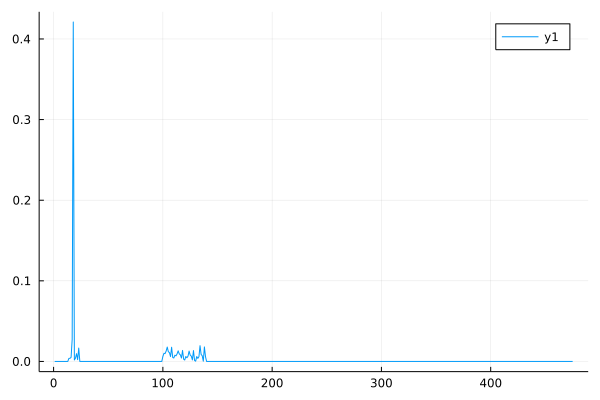

In [12]:
nume = numd_cls_nuisance(-0.01)
anal = ForwardDiff.derivative(diff_cls_nuisance, -0.01)
n = length(nume)
comp = zeros(Float64, n)

for i in 1:n 
    if (nume[i] != 0)
        comp[i] = @.(abs(anal[i]/nume[i] - 1))
    end
end

diff = []
for i in 1:n 
    if (nume[i] != 0)
        push!(diff, @.(abs(nume[i]-anal[i])))
    end
end
println(mean(diff))

plot(comp)

## Xi

In [19]:
cls_jaime1 = make_cls(carlos_params1);
cls_jaime2 = make_cls(carlos_params1; mode="emulator");

In [20]:
npzwrite("jaime_cls.npz", Dict("DESY1_cls_EisHu" => cls_jaime1,
                               "DESY1_cls_emul" => cls_jaime2))

In [21]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa12 = @. abs(cls_carlos["cls"]-cls_jaime2)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];
compa3 = @. abs(cls_carlos3["cls"]-cls_jaime1)/cls_carlos3["cls"];
compa4 = @. abs(cls_carlos4["cls"]-cls_jaime1)/cls_carlos4["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy default   ", mean(compa12))
println("Mean discrepancy no itp    ", mean(compa2))
println("Mean discrepancy no itp+EH ", mean(compa3))
println("Mean discrepancy no itp+EH+noconv ", mean(compa4))

Mean discrepancy default   0.07488758287333967
Mean discrepancy default   0.07914507993677818
Mean discrepancy no itp    0.072790699583588
Mean discrepancy no itp+EH 0.07243847354088799
Mean discrepancy no itp+EH+noconv 0.07001805856584456


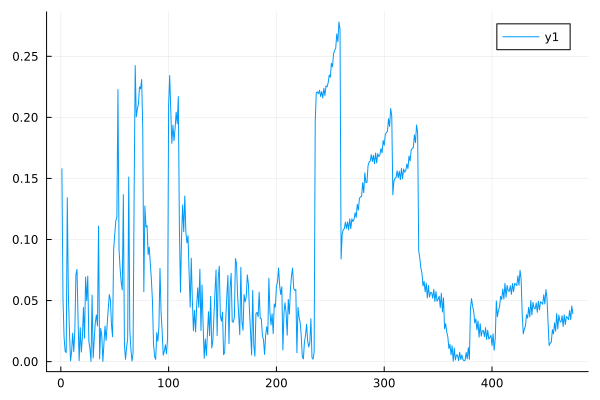

In [22]:
using Plots
plot(compa1)

In [23]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
chi2_carlos3 = cls_carlos3["chi2_nolp"]
chi2_carlos4 = cls_carlos4["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)
println(chi2_carlos3)
println(chi2_carlos4)

495.62231927779936
495.00947244084654
495.89420547809317
497.2051355000593


In [24]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
println(chi2_jaime1)

564.4237811372612


In [25]:
chi2_jaime2 = dot((cls_jaime2 .- data_vector), inv_cov_tot  * (cls_jaime2 .- data_vector))
println(chi2_jaime2)

571.5648149541164


In [26]:
(chi2_jaime1-chi2_carlos4)/chi2_carlos4

0.13519298341437563

# Turing model

In [17]:
@model function model(data_vector;
                      tracers_names=tracers_names,
                      pairs=pairs,
                      pairs_id=pairs_ids,
                      idx=idx,
                      cov_tot=cov_tot, 
                      files=files)
    
    #DESY1 priors
    Ωm ~ Uniform(0.1, 0.6)
    Ωb = 0.05 #~ Uniform(0.03, 0.045)
    h  = 0.67 #~ Uniform(0.60, 0.91)
    ns = 0.96 #~ Uniform(0.87, 1.07)
    s8 = 0.811 #~ Uniform(0.6, 0.9)
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    pairs_ids, idx, files)
    data_vector ~ MvNormal(theory, cov_tot)
end;

In [18]:
iterations = 300
nadapts = 100;

In [19]:
chain3 = sample(model(data_vector), NUTS(5, 0.1; init_ϵ=0.03), iterations,
                progress=true; save_state=true);

LoadError: UndefRefError: access to undefined reference

In [40]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:03


1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mangularCℓs[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mt1[39m::[0mNumberCountsTracer, [90mt2[39m::[0mWeakLensingTracer, [90mℓs[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m   @ [39m[35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mspectra.jl:30[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/PhD/LimberJack.jl/src/[39m[90m[4mtheory.jl:67[24m[39m[90m [inlined][39m
     [3] [0m[1m(::LimberJack.var"#23#threadsfor_fun#17"{Cosmology, Dict{String, Array}, Vector{Float64}, Vector{Int64}, Vector{Any}, Vector{SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, Vector{SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mLimberJack[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [4] [0m[1m(::LimberJack.var"#23#threadsfor_fun#17"{Cosmology, Dict{String, Array}, Vector{Float64}, Vector{Int64}, Vector{Any}, Vector{SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, Vector{SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mLimberJack[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m